## Analysis of Seinfeld Dialogue

## Cleaning Process

I first filter out rows that contain the word "Quote" as they are not actual dialogue and for the purposes of this project I want to focus on the dialogue.

In [1]:
import re   
import pandas as pd

seinfeld_data = pd.read_csv('C:/Users/james/OneDrive/Documents/Seths_Class_Repo/seinfeld_quotes.csv')

seinfeld_data = seinfeld_data.drop_duplicates()

word_to_remove = 'Quote'

df_filtered = seinfeld_data[~seinfeld_data.apply(lambda row: row.astype(str).str.contains(word_to_remove).any(), axis=1)]

Below I Contruct the dialogue to character dataframe which where I will perform sentiment analysis, topic modeling, and sarcasm detection. I used regex to remove any text that was in brackets as most of it was not part of the dialogue. I then split the dialogue into character and quote columns on the colon that seperated the name from the dialogue. I then removed any rows that contained numbers and the last three rows that did not contain dialogue.

In [2]:
df_filtered["Quote"] = df_filtered["Quote"].str.replace(r"\[.*?\]", "", regex=True).str.strip()

def split_dialogue(text):
    lines = text.split("\n")  
    extracted = []
    
    for line in lines:
        line = line.strip()  
        match = re.match(r"([^:]+):\s*(.*)", line)  
        if match:
            extracted.append(match.groups())  
    
    return extracted

full_clean = df_filtered['Quote'].apply(split_dialogue).explode().dropna().apply(pd.Series)

full_clean.columns = ['Character', 'Quotes']

full_clean = full_clean[~full_clean['Quotes'].str.match(r'^\w+[^\w\s]$')]

n = 3
full_clean.drop(full_clean.tail(n).index, inplace = True)


full_clean = full_clean[~full_clean['Quotes'].str.contains(r'\d')]

C:\Users\james\AppData\Local\Temp\ipykernel_34192\1909502842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Quote"] = df_filtered["Quote"].str.replace(r"\[.*?\]", "", regex=True).str.strip()


## Sentiment Analysis

Sentiment analysis using vader. Applied using lambda function to the Quotes column. I then found the top 10 most frequently occuring characters and filtered the dataframe to only include those characters. I then grouped by character and found the average sentiment score for each character which I then plotted on horizontal bar chart.

C:\Users\james\AppData\Local\Temp\ipykernel_34192\3635819939.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  horizontal_bar_plot =sns.barplot(x='Avg. Sentiment', y='Character', data=avg_character_sentiment, palette='pastel')


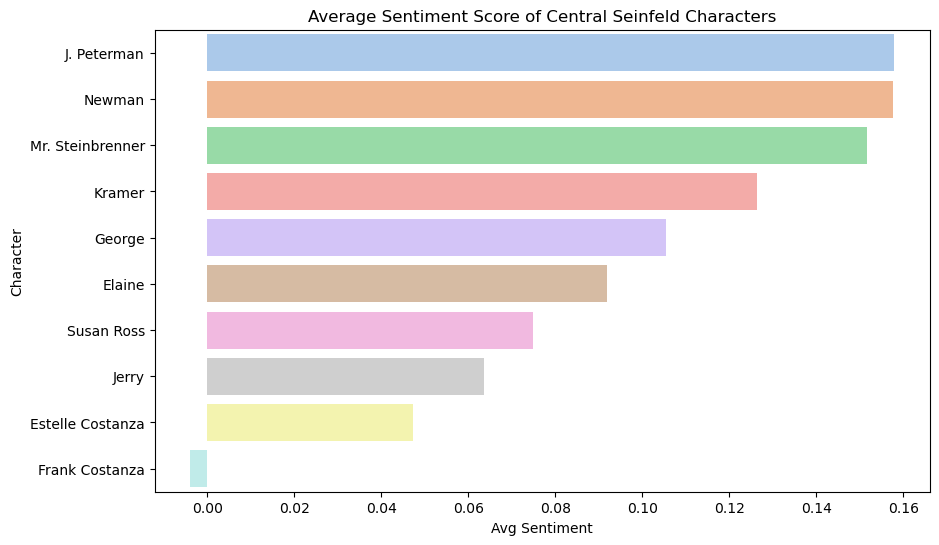

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


full_clean['Sentiment'] = full_clean['Quotes'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])


top_characters = full_clean['Character'].value_counts().head(10).index

top_character_sentiment = full_clean[full_clean['Character'].isin(top_characters)]


avg_character_sentiment = top_character_sentiment.groupby('Character')['Sentiment'].mean().sort_values(ascending=False)

avg_character_sentiment = pd.DataFrame(avg_character_sentiment)

avg_character_sentiment.rename(columns={'Sentiment': 'Avg. Sentiment'}, inplace=True)


plt.figure(figsize=(10, 6))
horizontal_bar_plot =sns.barplot(x='Avg. Sentiment', y='Character', data=avg_character_sentiment, palette='pastel')
plt.title('Average Sentiment Score of Central Seinfeld Characters')
plt.xlabel('Avg Sentiment')
plt.ylabel('Character')
plt.show()



## Topic Modeling

Then I use BERTopic modeling to find the most prevalent topics in the show. I preprocessed the text by tokenizing and lemmatizing the text with a function along with removing stopwords. I then apply the model. I then visualize the topics using an intertopic distance map, a bar chart containing distribution of words within each topic, and a similarity matrix.


In [16]:
from bertopic import BERTopic
#from bertopic.vectorizers import ClassTfidfTransformer
import nltk
import spacy

nltk.download('stopwords')
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_lg')

def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('english')]
    return ' '.join(tokens)

full_clean['Processed_Quotes'] = full_clean['Quotes'].apply(preprocess_text)

model = BERTopic()
topics, probabilities = model.fit_transform(full_clean['Processed_Quotes'])

topics_info = model.get_topic_info()
print(topics_info.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   Topic  Count                           Name  \
0     -1   2742          -1_get_little_go_life   
1      0    308           0_yo_demean_classic_   
2      1    270        1_jerry_jimmy_pong_ping   
3      2    215    2_george_zip_summer_georgie   
4      3    132  3_kramer_richie_flower_pretty   

                                      Representation  \
0  [get, little, go, life, try, like, would, know...   
1                [yo, demean, classic, , , , , , , ]   
2  [jerry, jimmy, pong, ping, leapin, larry, bass...   
3  [george, zip, summer, georgie, please, billy, ...   
4  [kramer, richie, flower, pretty, kramerica, is...   

                                 Representative_Docs  
0  [whole concept want poster get to wildly optim...  
1                                 [, classic, yo yo]  
2                              [jerry, jerry, jerry]  
3                           [george, george, george]  
4                           [kramer, kramer, kramer]  


In [19]:
dist_map = model.visualize_topics()
dist_map.show()

In [21]:
topic_word_scores = model.visualize_barchart(top_n_topics=12)
topic_word_scores.show()

In [22]:
heatmap = model.visualize_heatmap()
heatmap.show()

## Sarcasm Detection

I implemented a pre trained hugging face model to detect sarcasm. I then applied the model to the text and assigned a label and score to each quote using a function. I then filtered the dataframe to only include the top 10 most frequently occuring characters and then found the percentage of time that they would say something sarcastic. I then plotted the results on a horizontal bar chart.

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model_name = "jkhan447/sarcasm-detection-Bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sarcasm_detector = pipeline("text-classification", model=model, tokenizer=tokenizer)

sarcasm_detector.model.config.id2label

def detect_sarcasm(text):
    result = sarcasm_detector(text)[0]
    return result['label'], result['score']

full_clean[["Sarcasm_Label", "Sarcasm_Score"]] = full_clean["Quotes"].apply(lambda x: pd.Series(detect_sarcasm(x)))

Device set to use cpu


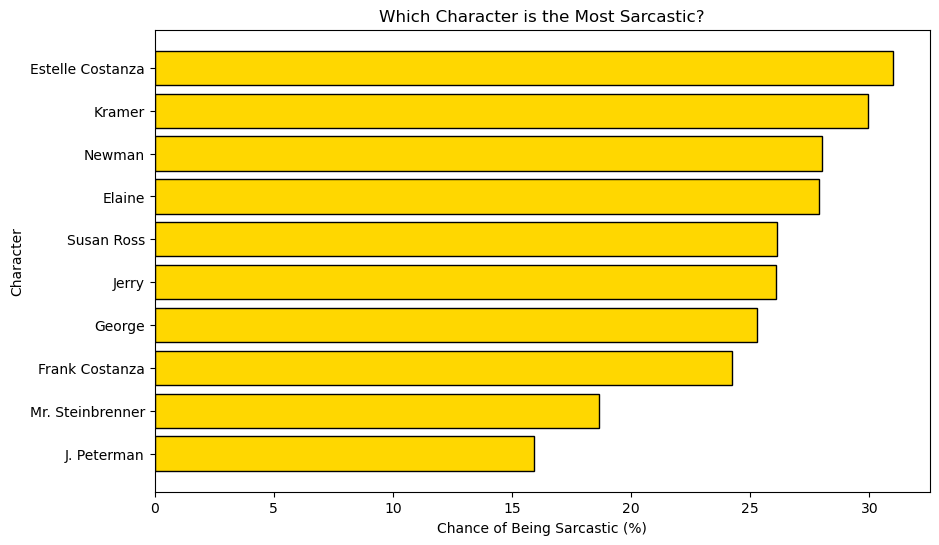

In [9]:
top_full_clean = full_clean[full_clean['Character'].isin(top_characters)]


sarcastic_counts = top_full_clean[top_full_clean['Sarcasm_Label'] == 'LABEL_1']['Character'].value_counts()


total_counts = top_full_clean['Character'].value_counts()


sarcastic_percentage = (sarcastic_counts / total_counts) * 100

sarcastic_percentage = sarcastic_percentage.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(sarcastic_percentage.index, sarcastic_percentage.values, color='gold', edgecolor='black')
plt.xlabel('Chance of Being Sarcastic (%)')
plt.ylabel('Character')
plt.title('Which Character is the Most Sarcastic?')
plt.gca().invert_yaxis()
plt.show()